In [1]:
%matplotlib inline

In [2]:
################################################################################
# SCRIPT ONE - READ DISTRIBUTION ANALYSIS FROM BASECALLED READS IN FASTA FILES #
################################################################################


### IMPORTING MODULES AND DEFINING INPUT-NECESSARY PARAMETERS ###

# Importing relevant modules: 
# * dataframe - pandas 
# * graphs - matplotlib 
# * tools - numpy, random, fnmatch, os
# * fasta to dataframe conversion - SeqIO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import shutil
import pandas as pd
import random
import collections
import math
from pandas.tools.plotting import table
from itertools import product
from Bio import SeqIO
from ete3 import NCBITaxa


# define root directory within which to create a subdirectory system
# define input paths for basecalled read fasta files, rgbesthit and ncbibesthit files
work_dir = os.path.abspath('../analysis/') + '/'
fasta_input_dir_path = os.path.abspath('../raw_fasta/')+ '/'
rgbesthit_input_dir_path = os.path.abspath('../blast/') + '/'
ncbibesthit_input_dir_path = os.path.abspath('../blast/')+ '/'


# parameters that need to be hard-coded: 
# - the barcodes tested for
# - the reference genome tag list, unique identifiers decided on from the sseqids of the ref genomes
# - the reference genome full species names, in the same order as the ref genome tags
good_barcodes = ['BC07', 'BC08', 'BC09', 'BC10', 'BC11']
ref_genome_tag_list = ['TGAC', 'Zymo', 'Ptri', 'Pst', 'tig']
ref_genome_species_list = ['Wheat', 
                        'Zymoseptoria tritici', 
                        'Pyrenophore tritici-repentis', 
                        'P. striformis f. sp. tritici WA', 
                        'Parastagonospora nodorum']


#-------------------------------------------------------------------------------

### CREATING THE SUBDIRECTORY SYSTEM INSIDE A SPECIFIED MAIN DIRECTORY ###

# Functions that generate main work directories and subdirectories for:
# * data (all fasta files)
# * blast (all blast output files)
# * analysis (all dataframe summary and graph files)
# when given a top directory path
def create_main_directories(top_dir):
    """Given a top work directory, creates 3 main subdirectories - data, blast and analysis"""
    main_directory_list = ['data/', 'blast/', 'output/']
    for new_direct in main_directory_list:
        if not os.path.exists(top_dir + new_direct):
            os.makedirs(top_dir + new_direct)

def create_data_subdirectories(top_dir):
    data_subdirectory_list = ['basecalled/',
                        'rghityes/',
                        'rghitno/',
                        'rghitsamples/']
    data_subsubdirectory_list = ['ncbihityes/',
                                 'ncbihitno/']
    for new_subdirect in data_subdirectory_list:
        if not os.path.exists(top_dir + 'data/' + new_subdirect):
            os.makedirs(top_dir + 'data/' + new_subdirect)
    for new_subsubdirect in data_subsubdirectory_list:
        if not os.path.exists(top_dir + 'data/rghitno/' + new_subsubdirect):
            os.makedirs(top_dir + 'data/rghitno/' + new_subsubdirect)

def create_blast_subdirectories(top_dir):
    blast_subdirectory_list = ['rgbesthit/',
                               'ncbibesthit/']
    for new_subdirect in blast_subdirectory_list:
        if not os.path.exists(top_dir + 'blast/' + new_subdirect):
            os.makedirs(top_dir + 'blast/' + new_subdirect)

def create_analysis_subdirectories(top_dir):
    analysis_subdirectory_list = ['graphs/',
                                  'tables/',
                               'summaries/']
    for new_subdirect in analysis_subdirectory_list:
        if not os.path.exists(top_dir + 'analysis/' + new_subdirect):
            os.makedirs(top_dir + 'analysis/' + new_subdirect)


# Apply previous functions to generate data, blast and analysis directories and subdirectories:
create_main_directories(work_dir)
create_data_subdirectories(work_dir)
create_blast_subdirectories(work_dir)
create_analysis_subdirectories(work_dir)


#-------------------------------------------------------------------------------

### MOVING THE BASECALLED FASTA FILES FROM AN INPUT FOLDER TO THE ~/DATA/BASECALLED SUB-DIRECTORY ###

# Define a function that extracts the file type from the fastas
def get_file_type(string, delimiter):
    file_type = string.split(delimiter)
    return delimiter + file_type[-1]


#Extracts fasta files from the initial input folder and moves them to ~/data/basecalled to be manipulated
fasta_input_file_names = [x for x in os.listdir(fasta_input_dir_path) if x.endswith('.fa')]
fasta_input_file_names.sort()
if fasta_input_file_names:
    for fasta_file in fasta_input_file_names:
        if os.path.exists(fasta_input_dir_path + fasta_file):
            if not os.path.exists(work_dir + 'data/basecalled/' + fasta_file):
                shutil.copy2(fasta_input_dir_path + fasta_file, work_dir + 'data/basecalled/' + fasta_file)
    fasta_file_type = get_file_type(fasta_input_file_names[-1], '.')

    
#-------------------------------------------------------------------------------

### EXTRACT BARCODES AND FASTA IDS FROM THE FASTA FILES IN ~/DATA/BASECALLED ###
  
#Generates a list of all fasta files present in data/basecalled
basecalled_file_names = os.listdir(work_dir + 'data/basecalled')
basecalled_fasta_file_names = [x for x in basecalled_file_names if x.endswith(fasta_file_type)]
basecalled_fasta_file_names.sort()


#Make a list of all available barcodes the basecalled reads are sorted into, based on fasta file names
basecalled_fasta_barcodes = []
for bcs in range(0, len(basecalled_fasta_file_names)):
    bclabel_index = ''
    if int(basecalled_fasta_file_names[bcs].rfind('BC')) > int(basecalled_fasta_file_names[bcs].rfind('NB')):
        bclabel_index = int(basecalled_fasta_file_names[bcs].rfind('BC'))
    else:
        bclabel_index = int(basecalled_fasta_file_names[bcs].rfind('NB'))
    basecalled_fasta_barcodes.append(basecalled_fasta_file_names[bcs][bclabel_index:bclabel_index + 4]) #Convert to a search parameter? Try this Yiheng!

####working up to here


In [3]:
#Extracts the ID from the basecalled file names (everything before BC/NB??.fa)
basecalled_fasta_file_id_list = []
for file_name in basecalled_fasta_file_names:
    print(file_name)
    bclabel_index = ''
    if int(file_name.rfind('BC')) > int(file_name.rfind('NB')):
        bclabel_index = int(file_name.rfind('BC'))
        basecalled_fasta_file_id_list.append(file_name[0:bclabel_index])
    else:
        bclabel_index = int(file_name.rfind('NB'))
        basecalled_fasta_file_id_list.append(file_name[0:bclabel_index])
  
basecalled_fasta_file_id = list(set(basecalled_fasta_file_id_list))[0]
#print(basecalled_fasta_file_id)  

2302_Wagga_1D_barcoding.Metrichor.BC00_2.pass.fa
2302_Wagga_1D_barcoding.Metrichor.BC07_2.pass.fa
2302_Wagga_1D_barcoding.Metrichor.BC08_2.pass.fa
2302_Wagga_1D_barcoding.Metrichor.BC09_2.pass.fa
2302_Wagga_1D_barcoding.Metrichor.BC10_2.pass.fa
2302_Wagga_1D_barcoding.Metrichor.BC11_2.pass.fa


In [4]:
#-------------------------------------------------------------------------------

### GENERATE SUMMARY OF ALL BASECALLED READS (READ ID, BARCODE, LENGTH, GOOD OR BAD BARCODE) ###

#Specifies all barcodes and bad barcodes (good_barcodes is previously defined)
all_barcodes = basecalled_fasta_barcodes
bad_barcodes = sorted(list(set(all_barcodes) - set(good_barcodes)))


#Create lengths.txt file to summarise read_id, barcode and length for basecalled reads, save in analysis/summaries/
analysis_summaries_path = work_dir + 'analysis/summaries/'
#maybe change the name of this variable
complete_path_and_name = os.path.join(analysis_summaries_path, basecalled_fasta_file_id + "lengths.txt")
lengths_txt = open(complete_path_and_name, "w")
print("Read_id,Barcode,Length,Quality", file=lengths_txt)


# From each read, write read_id, barcode, length, and good/bad barcode info into the text file.
# All other barcodes besides the good barcodes are labelled under 'NB00'
os.chdir(work_dir + 'data/basecalled/')
for bcs, fa_file in zip(basecalled_fasta_barcodes, basecalled_fasta_file_names):
    for seq in SeqIO.parse(open(fa_file), 'fasta'):
        if bcs in good_barcodes:
            print(seq.id + "," + bcs + "," + str(len(seq)) + "," + 'Good', file=lengths_txt)
        elif bcs in bad_barcodes:
            print(seq.id + "," + 'NB00' + "," + str(len(seq)) + "," + 'Bad', file=lengths_txt)
        else:
            continue
lengths_txt.close()
os.chdir(work_dir)

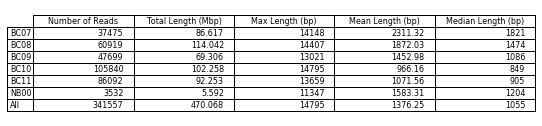

In [5]:
#-------------------------------------------------------------------------------

### ANALYSE BASECALLED READ SUMMARY (GET MAX, MIN, MEAN, MEDIAN, COUNT) ###

# Convert the lengths.txt file to a manipulatible pandas dataframe
basecalled_df = pd.read_csv(complete_path_and_name)


# Summarises the dataframe to show read count, sum, max, mean, median of read lengths per barcode
basecalled_df_pivot = basecalled_df.pivot_table(values='Length', 
                                                index='Barcode', 
                                                aggfunc=[len, np.sum, np.max, np.mean, np.median],
                                                fill_value=0, 
                                                margins=True)
basecalled_df_pivot.index.name = None

for clmns in ['len', 'amax', 'median']:
    basecalled_df_pivot[clmns] = basecalled_df_pivot[clmns].apply(lambda x: int(x))
basecalled_df_pivot['sum'] = basecalled_df_pivot['sum'].apply(lambda x: "{0:.3f}".format(int(x)/1000000))
basecalled_df_pivot['mean'] = basecalled_df_pivot['mean'].apply(lambda x: "{0:.2f}".format(x))
basecalled_df_pivot_formal = basecalled_df_pivot.copy() #titles have whitespace, make fancier
basecalled_df_pivot_formal.rename(columns={'len': 'Number of Reads', 
                                    'sum': 'Total Length (Mbp)',
                                    'amax': 'Max Length (bp)',
                                    'mean': 'Mean Length (bp)',
                                    'median': 'Median Length (bp)'}, inplace=True)


# Saves the table summary in the ~/analysis/tables/ subdirectory
fig = plt.figure(figsize=(9,2))
ax = fig.add_subplot(1, 1, 1, frame_on=False)
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, basecalled_df_pivot_formal, loc='center')

plt.savefig(os.path.join(work_dir + 'analysis/tables/', 
                        basecalled_fasta_file_id + "_basecalled_reads_summary.png"))



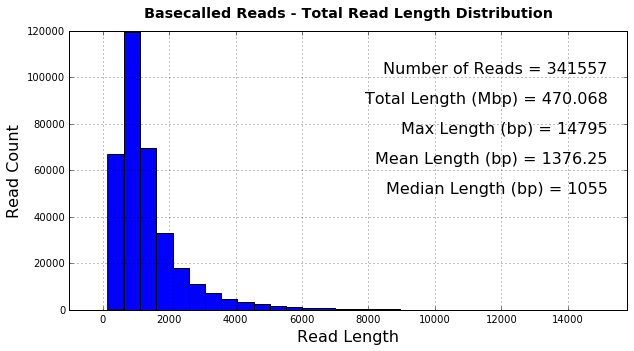

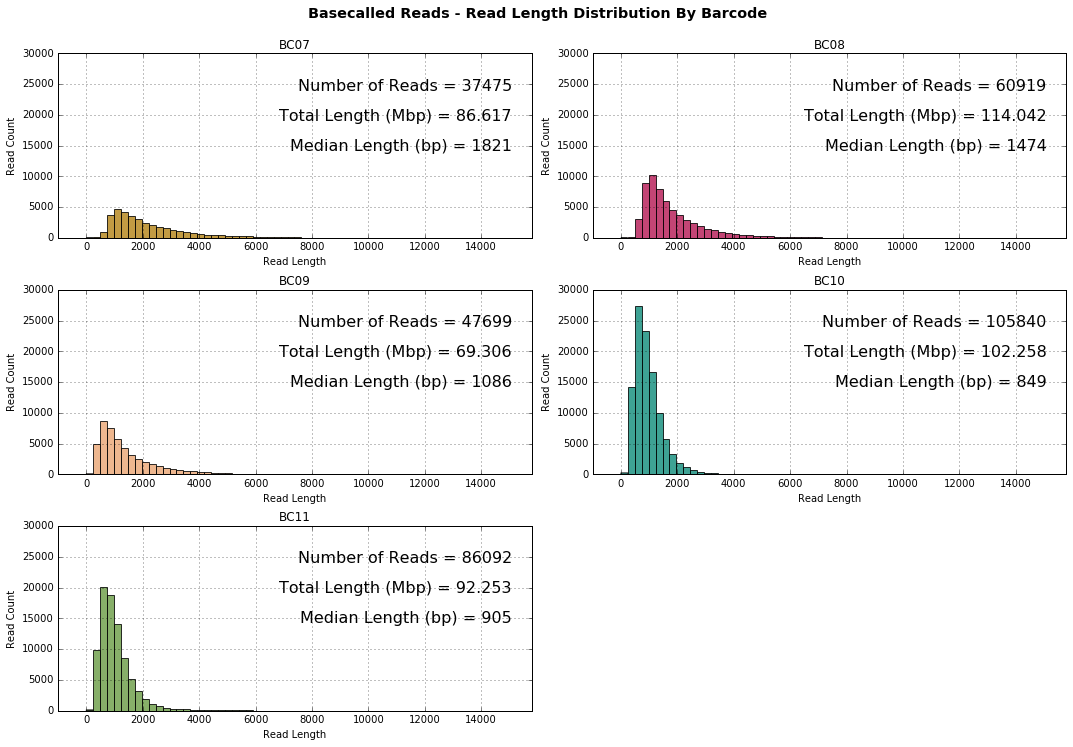

In [6]:

#-------------------------------------------------------------------------------

### CONSTRUCT HISTOGRAMS CHARTING READ DISTRIBUTION, BASED FROM THE DATAFRAME ###
bc_list = basecalled_df_pivot.index
bc_list = list(bc_list)
bc_list.remove('All')
# Function that generates a random colour
def random_color(x=1):
    r = lambda: random.randint(0,255)
    return ('#%02X%02X%02X' % (r(),r(),r()))


#Generates a histogram showing the total read length distribution for all basecalled reads
plt.figure(figsize=(10,5))
basecalled_df.Length.hist(bins=30)

plt.title('Basecalled Reads - Total Read Length Distribution', y=1.03, fontsize='x-large', fontweight='bold')

plt.xlabel('Read Length', fontsize=16)
plt.xticks(np.arange(0, basecalled_df.Length.max() + 1, 2000))
plt.xlim([-1000, basecalled_df.Length.max() + 1000])

plt.ylabel('Read Count', fontsize=16)

for idx, clmn_name in enumerate(list(basecalled_df_pivot_formal.columns)):
    plt.annotate(clmn_name + ' = ' + str(basecalled_df_pivot_formal[clmn_name]['All']), 
                 xy=(1, 1), 
                 xycoords='axes fraction', 
                 fontsize=16, 
                 fontweight='normal',
                 xytext=(-20, -30 - 30*idx), 
                 textcoords='offset points', 
                 ha='right', 
                 va='top')
    
plt.savefig(work_dir + 'analysis/graphs/' + basecalled_fasta_file_id + 'basecalled_read_distribution_total.png', bbox_inches='tight')


#Generates a histogram showing the total read length distribution for all basecalled reads per barcode
basecalled_barcodes = list(basecalled_df['Barcode'].unique())

if len(list(basecalled_df['Barcode'].unique())) % 2 == 0:
    no_of_subplots = len(basecalled_barcodes)
else:
    no_of_subplots = len(basecalled_barcodes) + 1

#Always 2 columns, bc-count/2 rows 
no_of_subplots_pair = [int(no_of_subplots/2), 2]

#Produce pairs of indices correlating to the coordinates of the subplots
subplot_coordinates = list(product(range(no_of_subplots_pair[0]), range(no_of_subplots_pair[1])))
subplot_coordinates_list = [list(l) for l in subplot_coordinates]
subplot_coordinates_list_rows = [i[0] for i in subplot_coordinates_list]
subplot_coordinates_list_columns = [i[1] for i in subplot_coordinates_list]

fig, ax = plt.subplots(no_of_subplots_pair[0], no_of_subplots_pair[1], figsize=(15,10))

xmax = int(basecalled_df.Length.max())

max_count_list = []
for bcs in list(basecalled_df['Barcode'].unique()):
    max_count_list.append(np.histogram(basecalled_df.loc[basecalled_df['Barcode'] == bcs]['Length'], 60)[0].max())
max_count_list.sort()
max_count_list_max = max_count_list[-1]
max_count_list_max_digits = len(str(max_count_list_max))
exact_ylim = (int(max_count_list_max / 10**(max_count_list_max_digits-1))+1)*(10**(max_count_list_max_digits-1))

def applyGroupHistograms(ax_ind1, ax_ind2, bcs):
    ax[ax_ind1, ax_ind2].hist(basecalled_df.groupby('Barcode')['Length'].get_group(bcs), 
                              bins=range(0, xmax, int(xmax/60)), 
                              color=random_color(), 
                              alpha=0.8)
    ax[ax_ind1, ax_ind2].set_title(bcs)
    ax[ax_ind1, ax_ind2].set_xlabel('Read Length')
    ax[ax_ind1, ax_ind2].set_ylabel('Read Count');
    ax[ax_ind1, ax_ind2].set_xlim([-1000, basecalled_df['Length'].max() + 1000])
    ax[ax_ind1, ax_ind2].set_xticks(np.arange(0, xmax + 1, 2000))
    ax[ax_ind1, ax_ind2].set_ylim(0, exact_ylim)
    ax[ax_ind1, ax_ind2].grid(True, which='Major')
    
    for idx, clmn_name in enumerate(['Number of Reads', 'Total Length (Mbp)', 'Median Length (bp)']):
        ax[ax_ind1, ax_ind2].annotate(clmn_name + ' = ' + str(basecalled_df_pivot_formal[clmn_name][bcs]), 
                     xy=(1, 1), 
                     xycoords='axes fraction', 
                     fontsize=16, 
                     fontweight='normal',
                     xytext=(-20, -25 - 30*idx), 
                     textcoords='offset points', 
                     ha='right', 
                     va='top')

for ax_ind1, ax_ind2, bcs, in zip(subplot_coordinates_list_rows, subplot_coordinates_list_columns, bc_list):
    applyGroupHistograms(ax_ind1, ax_ind2, bcs)    

if len(list(basecalled_df['Barcode'].unique())) != 0:
    plt.delaxes(ax[subplot_coordinates_list_rows[-1], subplot_coordinates_list_columns[-1]])

plt.suptitle('Basecalled Reads - Read Length Distribution By Barcode', 
             y=1.03, 
             fontsize='x-large', 
             fontweight='bold')
plt.tight_layout()
plt.savefig(work_dir + 'analysis/graphs/' + basecalled_fasta_file_id + 'basecalled_read_distribution_bcsort.png', bbox_inches='tight')    
    


In [ ]:
### DATAFRAME ANALYSIS - COLLATION OF RGBESTHIT DATA ###

In [8]:
#Extracts rgblast files from the initial input folder and moves them to data/basecalled to be manipulated
rgblast_input_file_names = [x for x in os.listdir(rgbesthit_input_dir_path) if x.endswith('WW_30032017.blast.besthit')]
rgblast_input_file_names.sort()
if rgblast_input_file_names:
    rgblast_file_type = get_file_type(rgblast_input_file_names[-1], '.')

    for rgblast_file in rgblast_input_file_names:
        if os.path.exists(rgbesthit_input_dir_path + rgblast_file):
            if not os.path.exists(work_dir + 'blast/rgbesthit/' + rgblast_file):
                shutil.copy2(rgbesthit_input_dir_path + rgblast_file, work_dir + 'blast/rgbesthit/' + rgblast_file)

In [10]:
# creates a list of all the reference genome blast besthit file names in blast/rgbesthit
rgblast_file_names = os.listdir(work_dir + 'blast/rgbesthit')
rgblast_besthit_file_names = [x for x in rgblast_file_names if rgblast_file_type in x]
rgblast_besthit_file_names.sort()

In [11]:
#Extracts the reference genome blast id from the rgblast hit file names
rgblast_file_id_list = []
for file_name in rgblast_besthit_file_names:
    start = file_name.find(fasta_file_type)
    end = file_name.find(rgblast_file_type)
    rgblast_file_id_list.append(file_name[start+len(fasta_file_type):end])
rgblast_file_id = list(set(rgblast_file_id_list))[0]

In [13]:
#Make a list of all available barcodes the rgbesthit reads are sorted into, based on rgbesthit file names
#blast_besthit_file_names_idstrip = [file_name.strip(basecalled_fasta_file_id) for file_name in rgblast_besthit_file_names]
rgblast_besthit_barcodes =[]
for bcs in range(0, len(rgblast_besthit_file_names)):
    bclabel_index = ''
    if int(rgblast_besthit_file_names[bcs].find('BC')) > int(rgblast_besthit_file_names[bcs].find('NB')):
        bclabel_index = int(rgblast_besthit_file_names[bcs].find('BC'))
    else:
        bclabel_index = int(rgblast_besthit_file_names[bcs].find('NB'))
    rgblast_besthit_barcodes.append(rgblast_besthit_file_names[bcs][bclabel_index:bclabel_index + 4])

In [14]:
#Makes a dictionary - key (barcode) : value (dataframe of rgblast hit results per barcode)
os.chdir(work_dir + 'blast/rgbesthit')
rgblast_dfs_dict = {}
blast_output_parameters = ['qseqid', 'sseqid', 'evalue', 'bitscore', 'length', 'pident', 'nident']
rgblast_besthit_barcodes.sort()
rgblast_besthit_file_names.sort()
for bcs, besthit_file in zip(rgblast_besthit_barcodes, rgblast_besthit_file_names):
    if rgblast_file_id in besthit_file:
        rgblast_dfs_dict[bcs] = pd.read_table(besthit_file, delim_whitespace=True, 
                                           names=blast_output_parameters) #hardcoded
for bcs in rgblast_dfs_dict.keys():
    rgblast_dfs_dict[bcs]['barcode'] = bcs
os.chdir(work_dir)

In [15]:
# NECESSARY TO HARD CODE - Must supply two lists of equal length, in the desired order: 
# one corresponding to unique letter combos in the sseqid ids (tags)
# one corresponding to the full names of the reference genomes used

def assign_species_from_sseqid(x):
    for rg_tag, rg_full in zip(ref_genome_tag_list, ref_genome_species_list):   

#might want to consider making this a pattern match
#this needs to be changed when changing the initial inhouse database

        if rg_tag in str(x):
            return rg_full
    else:
        return 'N/A'

for bcs in rgblast_dfs_dict.keys():
    rgblast_dfs_dict[bcs]['species'] = rgblast_dfs_dict[bcs]['sseqid'].apply(assign_species_from_sseqid)


In [16]:
#Combining the BC00 reads from BLAST
if 'BC00' in rgblast_dfs_dict.keys():
    rgblast_dfs_dict['BC00']['barcode'] = 'NB00'

#Combine all the reference genome hit dataframes across all barcodes
rgblast_df_list = []
for bcs in rgblast_dfs_dict.keys():
    rgblast_df_list.append(rgblast_dfs_dict[bcs])
    
rgblast_df_joint = pd.concat(rgblast_df_list, axis=0, ignore_index=True)
rgblast_df_joint.sort_values('barcode', ascending=True, inplace=True)
rgblast_df_joint.reset_index(drop=True, inplace=True)

In [17]:
#Create a pivot table showing all reference genome hit counts for each barcode
rgblast_df_joint_pivot = rgblast_df_joint.pivot_table(values='nident', index='barcode', columns='species', aggfunc='count', fill_value=0, margins=True)
rgblast_df_joint_pivot = rgblast_df_joint_pivot.applymap(int)
rgblast_df_joint_pivot.index.name = None
rgblast_df_joint_pivot.columns.name = None

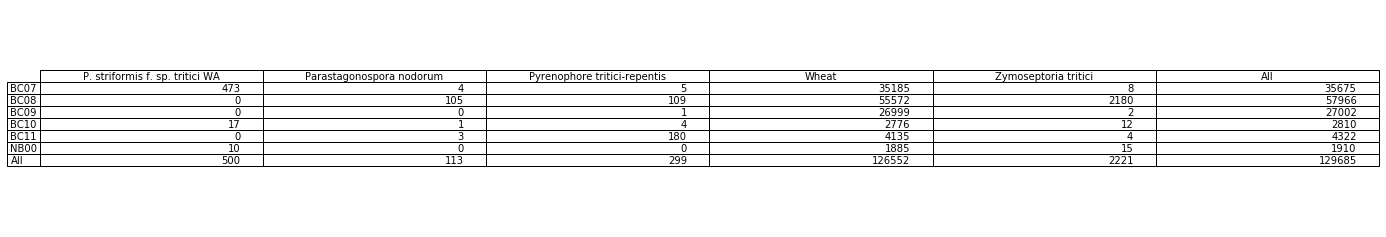

In [18]:
#Save pivot table to analysis/tables/
fig = plt.figure(figsize=(24,4))
ax = fig.add_subplot(1, 1, 1, frame_on=False)
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, rgblast_df_joint_pivot, loc='center')

plt.savefig(os.path.join(work_dir + 'analysis/tables/', 
                        basecalled_fasta_file_id + "_rgblasthit_reads_summary.png"))


In [19]:
#Removes the 'all' column (for graphing purposes)
rgblast_df_joint_pivot_noall = rgblast_df_joint_pivot.drop('All', axis=1)

In [20]:
# Construct a grouped bar chart showing the reference genome hit counts per barcode (log y axis)
def generateGBGforRGHC(dropmaxspecies=False):
    n_groups = len(rgblast_df_joint_pivot_noall.index.values)

    max_genome = str(rgblast_df_joint_pivot_noall.ix['All'].idxmax(axis=1))

    spc_list = list(rgblast_df_joint_pivot_noall.columns)
    
    if dropmaxspecies == True:
        spc_list.remove(max_genome)

    n_species_dict = {}
    for spc in spc_list:
        n_species_dict[spc] = tuple(rgblast_df_joint_pivot_noall[spc])

    n_nohit = tuple(basecalled_df_pivot['len'].values - rgblast_df_joint_pivot['All'].values)    
    
    fig, ax = plt.subplots(figsize=(7,3))

    index = np.arange(n_groups)
    bar_width = 0.13
    opacity = 0.4

    if dropmaxspecies == False:
        plt.bar(index - bar_width*2, 
            n_nohit, 
            bar_width,
            alpha = opacity,
            log = True,
            color = 'k',
            label = 'No Hit')

        for idx, spc in enumerate(spc_list):
            plt.bar(index - bar_width + bar_width*idx, 
                n_species_dict[spc], 
                bar_width,
                alpha = opacity,
                log = True,
                color = random_color(),
                label = spc)
    else:
        for idx, spc in enumerate(spc_list):
            plt.bar(index - bar_width + bar_width*idx, 
                n_species_dict[spc], 
                bar_width,
                alpha = opacity,
                color = random_color(),
                label = spc)
            
    def generate_upper_ylim(graph_max):
        """Takes a value, counts the digits and outputs a value corresponding to 10*digits"""
        digits = len(str(graph_max))
        round_up = 10**(digits)
        return round_up

    plt.xlabel('Barcode')
    plt.xticks(index + bar_width*1.2, tuple(rgblast_df_joint_pivot_noall.index.values))

    plt.ylabel('Number of Reads')
    if dropmaxspecies == False:
        plt.ylim(0, generate_upper_ylim(rgblast_df_joint_pivot['All'].values.max()))
    else:
        rgblast_df_joint_pivot_nomaxspecies = rgblast_df_joint_pivot_noall.copy()
        rgblast_df_joint_pivot_nomaxspecies.drop(max_genome, axis=1, inplace=True)
        rgblast_df_joint_pivot_nomaxspecies['All'] = rgblast_df_joint_pivot_nomaxspecies.sum(axis=1)
        plt.ylim(0, (rgblast_df_joint_pivot_nomaxspecies['All'].values.max()+1)/2)

    plt.title('Number of Reads Hitting Specific Reference Genomes', y=1.08)
    plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=10)
    plt.grid(b=None, which='major', axis='y', linestyle='dashed', linewidth=0.2)
    plt.margins(x=0.1)
    plt.tick_params(top="off", right="off", bottom='off')
    plt.tight_layout()
    if dropmaxspecies == False:
        plt.savefig(work_dir + 'analysis/graphs/' + basecalled_fasta_file_id + 'ref_genome_hit_counts.png', bbox_inches='tight')
    else:
        plt.savefig(work_dir + 'analysis/graphs/' + basecalled_fasta_file_id + 'ref_genome_hit_counts_nomaxspecies.png', bbox_inches='tight')

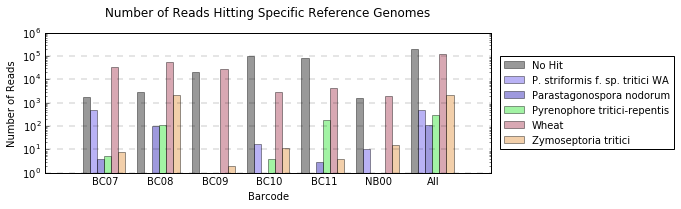

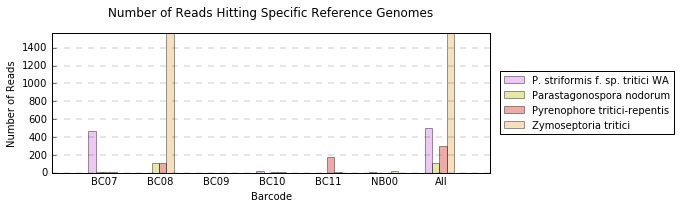

In [21]:
#Generate the graphs
generateGBGforRGHC(dropmaxspecies=False)
generateGBGforRGHC(dropmaxspecies=True)

In [ ]:
#Changes rgblast pivot table count results to rgblast % within each barcode
rgblast_joint_pivot_table_pc = rgblast_df_joint_pivot.copy()

for spcs in rgblast_joint_pivot_table_pc.columns:
    rgblast_joint_pivot_table_pc[str(spcs) + '%'] = np.round((rgblast_joint_pivot_table_pc[spcs] / rgblast_joint_pivot_table_pc['All'] * 100), 3)
for spcs in rgblast_joint_pivot_table_pc.columns:
    if '%' not in spcs:
        rgblast_joint_pivot_table_pc.drop(spcs, axis=1, inplace=True)
    
rgblast_joint_pivot_table_pc.drop('All%', axis=1, inplace=True)

In [ ]:
# Construct a grouped bar chart showing the reference genome hit % per barcode (log y axis)
def generateGBGPCforRGHC(dropmaxspecies=False):
    n_groups = len(rgblast_joint_pivot_table_pc.index.values)

    max_genome = str(rgblast_joint_pivot_table_pc.ix['All'].idxmax(axis=1))

    pos = list(range(len(rgblast_joint_pivot_table_pc[max_genome])))
    width = 0.15
    
    columns_pc = list(rgblast_joint_pivot_table_pc.columns)
    columns_nopc = list(map(lambda x:x.strip("%"), columns_pc))
    if dropmaxspecies == True:
        columns_pc = [x for x in columns_pc if x != max_genome]
        columns_nopc = [x for x in columns_nopc if x != max_genome.strip('%')]
    
    barcodes = list(rgblast_joint_pivot_table_pc.index)
    fig, ax = plt.subplots(figsize=(8,3))

    for ref_genome in columns_pc:  
        plt.bar([p + width*int(columns_pc.index(ref_genome)) for p in pos], 
                rgblast_joint_pivot_table_pc[ref_genome], 
                width, 
                alpha=0.5, 
                color=random_color(x), 
                label=None)
        
    ax.set_ylabel('% of Reads', fontsize=14)
    
    rgblast_joint_pivot_table_pc_nomaxspecies = rgblast_joint_pivot_table_pc.copy()
    rgblast_joint_pivot_table_pc_nomaxspecies.drop(max_genome, axis=1, inplace=True)
    rgblast_joint_pivot_table_pc_nomaxspecies['All'] = rgblast_joint_pivot_table_pc_nomaxspecies.sum(axis=1)
    
    ax.set_ylim([0, int(rgblast_joint_pivot_table_pc_nomaxspecies['All'].values.max()+1)])
    ax.set_yticks(range(0, int(rgblast_joint_pivot_table_pc_nomaxspecies['All'].values.max()+2), 1))
    ax.set_xlabel('Barcode', fontsize=14)
    ax.set_xticks([p + 2.5 * width for p in pos])
    ax.set_xticklabels(barcodes)
    ax.tick_params(top="off", right="off", bottom='off')
    ax.set_title('Reads Hitting Reference Genomes - % Hit Per Genome By Barcode', y=1.08, fontweight='bold', fontsize=16)
    
    if dropmaxspecies == False:
        for idx, bcs in enumerate(barcodes):
            ax.annotate(str(float("{0:.2f}".format(rgblast_joint_pivot_table_pc[max_genome][bcs]))), 
                     xy=(0.06, 0.95), xycoords='axes fraction', fontsize=10, xytext=(55*idx, 0), textcoords='offset points', 
                     ha='left', va='top')
    
    plt.xlim(min(pos) - width, max(pos) + 0.3 + width*4)
    plt.legend(columns_nopc, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=18, prop={'weight':'normal'})
    plt.grid(b=None, which='major', axis='y', linestyle='dashed', linewidth=0.2)
    if dropmaxspecies == False:
        plt.savefig(work_dir + 'analysis/graphs/' + basecalled_fasta_file_id + 'ref_genome_hit_percentage.png', bbox_inches='tight')
    else:
        plt.savefig(work_dir + 'analysis/graphs/' + basecalled_fasta_file_id + 'ref_genome_hit_percentage_nomaxspecies.png', bbox_inches='tight')

In [ ]:
#Construct the graphs
generateGBGPCforRGHC(dropmaxspecies=False)
generateGBGPCforRGHC(dropmaxspecies=True)

In [ ]:
#Generate subsamples of your reference genome hits to be blasted
os.chdir(work_dir + 'data/basecalled/')
blast_hit_sample_id = ".blasthitsample_"
data_rghitsamples_path = work_dir + 'data/rghitsamples/'

def generate_blasthit_samples(bcs, smp, rpts):
    for rpt in range(1, rpts+1):
        
        rgblast_df_joint_sample = rgblast_df_joint.loc[rgblast_df_joint['barcode'] == str(bcs)].sample(n = smp)
        rgblast_df_joint_sample_list = list(rgblast_df_joint_sample['qseqid'].values)
        
        rgblasthitsample_id = rgblast_file_id + blast_hit_sample_id + str(rpt) + fasta_file_type
        rgblasthitsample_file = basecalled_fasta_file_id + bcs + rgblasthitsample_id

        rgblasthitsample_sequences = []
        if bcs == 'NB00':
            for badbcs in bad_barcodes:
                for seq in SeqIO.parse(open(basecalled_fasta_file_id + str(badbcs) + fasta_file_type), 'fasta'):
                    if seq.id in rgblast_df_joint_sample_list:
                        rgblasthitsample_sequences.append(seq)
            SeqIO.write(rgblasthitsample_sequences, os.path.join(data_rghitsamples_path, 
                                                                 rgblasthitsample_file), "fasta")
        else:
            for seq in SeqIO.parse(open(basecalled_fasta_file_id + str(bcs) + fasta_file_type), 'fasta'):
                if seq.id in rgblast_df_joint_sample_list:
                    rgblasthitsample_sequences.append(seq)
            SeqIO.write(rgblasthitsample_sequences, os.path.join(data_rghitsamples_path, 
                                                                 rgblasthitsample_file), "fasta")
        
            

In [ ]:
# Generate samples
for bcs in good_barcodes:
    generate_blasthit_samples(bcs, 1000, 3)
generate_blasthit_samples('NB00', 500, 3)

In [ ]:
#def generate_notblasted_counts(bcs):
    #read_id_list = ''
    #read_id_list = basecalled_df.groupby('Barcode')['Read_id'].get_group(bcs).tolist()
    #qseqid_list = ''
    #qseqid_list = rgblast_df_joint.groupby('barcode')['qseqid'].get_group(bcs).tolist()
    #not_rgblasted_list = sorted(list(set(read_id_list) - set(qseqid_list)))
    #print(len(read_id_list))
    #print(len(qseqid_list))
    #print(len(not_rgblasted_list))
    
#generate_notblasted_counts('BC03')

In [ ]:
#Generates fasta files with/without the reads hitting the reference genomes, 
#sorts them to their appropriate folder location
os.chdir(work_dir + 'data/basecalled/')
def generate_rghit_fasta(bcs, rghit):
    """Takes basecalled.df, and list of read_ids from rgblast_df_joint. For a single barcode:
    - if rghit is yes, extract a fasta file with all the reads hitting the reference genomes to data/rghityes
    - if rghit is no, extract a fasta file with all the reads not hitting the reference genomes to data/rghitno"""
    os.chdir(work_dir + 'data/basecalled/')
    read_id_list = basecalled_df.groupby('Barcode')['Read_id'].get_group(bcs).tolist()
    qseqid_list = rgblast_df_joint.groupby('barcode')['qseqid'].get_group(bcs).tolist()

    if rghit == 'Yes':
        rgblasted_hit_id = '.blasthit'
        rgblasthit_id = rgblast_file_id + rgblasted_hit_id + fasta_file_type
        rgblasthit_file = basecalled_fasta_file_id + bcs + rgblasthit_id
        
        if bcs == 'NB00':
            rghityes = []
            for badbcs in bad_barcodes:
                rghityes_NB00 = ''
                rghityes_NB00 = (rec for rec in SeqIO.parse(basecalled_fasta_file_id + str(badbcs) + fasta_file_type, 'fasta') if rec.id in qseqid_list) 
                rghityes.extend(rghityes_NB00)
            count = ''
            count = SeqIO.write(rghityes, os.path.join(work_dir + 'data/rghityes/', rgblasthit_file), "fasta")
        else:
            rghityes = ''
            rghityes = (rec for rec in SeqIO.parse(basecalled_fasta_file_id + str(bcs) + fasta_file_type, 'fasta') if rec.id in qseqid_list) 
            count = ''
            count = SeqIO.write(rghityes, os.path.join(work_dir + 'data/rghityes/', rgblasthit_file), "fasta")
            
    if rghit == 'No':   
        norgblasted_hit_id = '.noblasthit'
        norgblasthit_id = rgblast_file_id + norgblasted_hit_id + fasta_file_type
        norgblasthit_file = basecalled_fasta_file_id + bcs + norgblasthit_id
        
        if bcs == 'NB00':
            rghitno = []
            for badbcs in bad_barcodes:
                rghitno_NB00 = ''
                rghitno_NB00 = (rec for rec in SeqIO.parse(basecalled_fasta_file_id + str(badbcs) + fasta_file_type, 'fasta') if rec.id not in qseqid_list) 
                rghitno.extend(rghitno_NB00)
            count = ''
            count = SeqIO.write(rghitno, os.path.join(work_dir + 'data/rghitno/', norgblasthit_file), "fasta")
        else:
            rghitno = ''
            rghitno = (rec for rec in SeqIO.parse(basecalled_fasta_file_id + str(bcs) + fasta_file_type, 'fasta') if rec.id not in qseqid_list) 
            count = ''
            count = SeqIO.write(rghitno, os.path.join(work_dir + 'data/rghitno/', norgblasthit_file), "fasta")

In [ ]:
for bcs in list(rgblast_df_joint.barcode.unique()):
    generate_rghit_fasta(bcs, 'Yes')

In [ ]:
for bcs in list(rgblast_df_joint.barcode.unique()):
    generate_rghit_fasta(bcs, 'No')

In [ ]:
#create a table summarising blasted counts, hit vs no hit counts and %
rgblasted_count_df = pd.concat([basecalled_df_pivot['len'], rgblast_df_joint_pivot['All']],  axis=1)
rgblasted_count_df.applymap(lambda x: int(x))
rgblasted_count_df.rename(columns={'len' : 'RGCount', 'All' : 'RGHitYes'}, inplace=True)
rgblasted_count_df['RGHitNo'] = rgblasted_count_df['RGCount'] - rgblasted_count_df['RGHitYes']
rgblasted_count_df['RGHitYes%'] = np.round((rgblasted_count_df['RGHitYes'] / rgblasted_count_df['RGCount'] * 100), 3)
rgblasted_count_df['RGHitNo%'] = np.round((rgblasted_count_df['RGHitNo'] / rgblasted_count_df['RGCount'] * 100), 3)

In [ ]:
rgblasted_count_df_noall = rgblasted_count_df.drop('All')

In [ ]:
### Saves pivot table summary in analysis/tables/ folder ###
fig = plt.figure(figsize=(10,2))
ax = fig.add_subplot(1, 1, 1, frame_on=False)
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, rgblasted_count_df, loc='center')

plt.savefig(os.path.join(work_dir + 'analysis/tables/', 
                        basecalled_fasta_file_id + "rgblast_hit_vs_nohit_summary.png"))

In [ ]:
#two qualitative variables - barcode, blasted vs no hit vs hit
#one quantitative - read count
n_groups = len(rgblasted_count_df_noall.index.values)

bar_labels = ['Blasted', 'Blasted and Hit', 'Blasted and No Hit']
counts = [tuple(rgblasted_count_df_noall['RGCount']),
          tuple(rgblasted_count_df_noall['RGHitYes']),
          tuple(rgblasted_count_df_noall['RGHitNo'])]

fig, ax = plt.subplots(figsize=(6.5,3))

index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.4

for idx, (lbl, cnts) in enumerate(zip(bar_labels, counts)):
    plt.bar(index + bar_width*idx, cnts, bar_width,
                 alpha=opacity,
                 color=random_color(x),
                 label=lbl)
    
plt.xlabel('Barcode')
plt.ylabel('Read Count')
plt.title('Number of Reads Blasted and Hit To Reference Genomes', y=1.08)
plt.xticks(index + bar_width*1.5, tuple(rgblasted_count_df_noall.index.values))
plt.tick_params(right='off', top='off', bottom='off')
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=10)
plt.grid(b=None, which='major', axis='y', linestyle='dashed', linewidth=0.2)
plt.margins(x=0.1)

plt.tight_layout()
plt.savefig(work_dir + 'analysis/graphs/' + basecalled_fasta_file_id + 'ref_genome_hit_and_nohit_counts.png', bbox_inches='tight')

In [ ]:
#two qualitative variables - barcode, no hit vs hit
#one quantitative - read count
n_groups = len(rgblasted_count_df_noall.index.values)

bar_labels = ['Blasted and Hit', 'Blasted and No Hit']
counts = [tuple(rgblasted_count_df_noall['RGHitYes%']),
          tuple(rgblasted_count_df_noall['RGHitNo%'])]

fig, ax = plt.subplots(figsize=(6.5,3))

index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.4

for idx, (lbl, cnts) in enumerate(zip(bar_labels, counts)):
    plt.bar(index + bar_width*idx, cnts, bar_width,
                 alpha=opacity,
                 color=random_color(x),
                 label=lbl)

plt.xlabel('Barcode')
plt.ylabel('% of Reads Per Barcode')
plt.title('% of Reads Blasted and Hit To Reference Genomes', y=1.08)
plt.xticks(index + bar_width, tuple(rgblasted_count_df_noall.index.values), y=-0.01)
plt.tick_params(top='off', right='off')
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=12)
plt.grid(b=None, which='major', axis='y', linestyle='dashed', linewidth=0.2)
plt.margins(x=0.1)

plt.tight_layout()
plt.savefig(work_dir + 'analysis/graphs/' + basecalled_fasta_file_id + 'ref_genome_hit_and_nohit_percentage.png', bbox_inches='tight')

In [ ]:
#Generate taxonomic database from ete3
ncbi = NCBITaxa()

In [ ]:
#Extracts ncbiblast files from the initial input folder and moves them to data/basecalled to be manipulated
ncbiblast_input_file_names = os.listdir(ncbiblast_input_dir_path)
ncbiblast_input_file_names.sort()
if ncbiblast_input_file_names:
    ncbiblast_file_type = get_file_type(ncbiblast_input_file_names[-1], '.')

    for ncbiblast_file in ncbiblast_input_file_names:
        if os.path.exists(ncbiblast_input_dir_path + ncbiblast_file):
            if not os.path.exists(work_dir + 'blast/ncbibesthit/' + ncbiblast_file):
                os.rename(ncbiblast_input_dir_path + ncbiblast_file, work_dir + 'blast/ncbibesthit/' + ncbiblast_file)

In [ ]:
#Gets a list of all the ncbiblast hit file names from .blast/ncbibesthit
# creates a list of all the reference genome blast besthit file names
#Generates a list of all the fasta files present in data/basecalled
ncbiblast_file_names = os.listdir(work_dir + 'blast/ncbibesthit')
ncbiblast_besthit_file_names = [x for x in ncbiblast_file_names if ncbiblast_file_type in x]
ncbiblast_besthit_file_names.sort()

In [ ]:
#Extracts the ncbi blast id from the ncbiblast hit file names
ncbiblast_file_id_list = []
for file_name in ncbiblast_besthit_file_names:
    start = file_name.find(fasta_file_type)
    end = file_name.rfind(ncbiblast_file_type)
    ncbiblast_file_id_list.append(file_name[start+len(fasta_file_type):end])
ncbiblast_file_id = list(set(ncbiblast_file_id_list))[0]

In [ ]:
#Make a list of all available barcodes the ncbibesthit reads are sorted into, based on ncbibesthit file names
ncbiblast_besthit_file_names_idstrip = [file_name.strip(basecalled_fasta_file_id) for file_name in ncbiblast_besthit_file_names]
ncbiblast_besthit_barcodes = []
for bcs in range(0, len(ncbiblast_besthit_file_names_idstrip)):
    bclabel_index = ''
    if int(ncbiblast_besthit_file_names_idstrip[bcs].find('BC')) > int(ncbiblast_besthit_file_names_idstrip[bcs].find('NB')):
        bclabel_index = int(ncbiblast_besthit_file_names_idstrip[bcs].find('BC'))
    else:
        bclabel_index = int(ncbiblast_besthit_file_names_idstrip[bcs].find('NB'))
    ncbiblast_besthit_barcodes.append(ncbiblast_besthit_file_names_idstrip[bcs][bclabel_index:bclabel_index + 4])

In [ ]:
#Reads each ncbiblast_besthit file as a dataframe, appends a column with the relevant barcode
os.chdir(work_dir + 'blast/ncbibesthit')
ncbiblast_dfs_dict = {}
blast_output_parameters = ['qseqid', 'sseqid', 'evalue', 'bitscore', 'length', 
                           'pident', 'nident', 'sgi', 'sacc', 'staxids', 'sscinames', 
                           'scomnames', 'sskingdoms', 'barcode']
for bcs, besthit_file in zip(ncbiblast_besthit_barcodes, ncbiblast_besthit_file_names):
    if ncbiblast_file_id in besthit_file:
        ncbiblast_dfs_dict[bcs] = pd.read_table(besthit_file, 
                                                delim_whitespace=False,
                                                names=blast_output_parameters) #hardcoded
for bcs in ncbiblast_dfs_dict.keys():
    ncbiblast_dfs_dict[bcs]['barcode'] = bcs

In [ ]:
#Combining the bad barcode reads from BLAST into NB00
if 'BC00' in ncbiblast_dfs_dict.keys():
    ncbiblast_dfs_dict['BC00']['barcode'] = 'NB00'

#Joining the dataframes for individual barcodes together
ncbiblast_df_list = []
for bcs in ncbiblast_dfs_dict.keys():
    ncbiblast_df_list.append(ncbiblast_dfs_dict[bcs])
    
ncbiblast_df_joint = pd.concat(ncbiblast_df_list, axis=0, ignore_index=True)
ncbiblast_df_joint.sort_values('barcode', ascending=True, inplace=True)
ncbiblast_df_joint.reset_index(drop=True, inplace=True)

In [ ]:
#Function to generate taxonomy columns based on NCBITaxa results for NCBI hit dataframe, 
#Appends these taxcnomy columns to the joint ncbiblast dataframe
def search_rank_output_name_append_column(df, staxid_column, rank_search):
    """Input df, staxid_column from same df and rank_search (a desired taxonomic rank 
    from each staxid's lineage), outputs taxonomic name corresponding to rank_search or 'Unclassified' if
    unavailable and appends to df row by row"""
    rank_list = []
    for read_ind in range(0, len(staxid_column)):
        taxid = ''
        if ';' in str(staxid_column[read_ind]):
            taxid = staxid_column[read_ind].split(';')[0]
        else:
            taxid = staxid_column[read_ind]
        
        taxid_lineage = ''
        taxid_lineage = ncbi.get_lineage(taxid)
        
        names = ''
        names = ncbi.get_taxid_translator(taxid_lineage)
        
        ranks = ''
        ranks = ncbi.get_rank(taxid_lineage) #Dict
        
        ranks2names = ''
        ranks2names = {ranks[k]:names[k] for k in names.keys() & ranks}
        
        if rank_search in ranks2names.keys():
            rank_list.append(ranks2names[rank_search])#if rank in dict, print name
        else:
            rank_list.append('Unclassified')
    df[rank_search] = rank_list
# NOTE: Appending is always slow, try and find a better way e.g df.apply to a column based on staxids column

In [ ]:
#Appends columns to joint_NCBI_df_taxonomy corresponding to desired taxonomic ranks for metagenomic analysis
ncbiblast_df_joint_taxonomy = ncbiblast_df_joint.copy()
main_taxonomic_ranks = ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
for ranks in main_taxonomic_ranks:
    search_rank_output_name_append_column(ncbiblast_df_joint_taxonomy, 
                                          ncbiblast_df_joint_taxonomy['staxids'], 
                                          ranks)
    
#Removing unncessary columns from joint_NCBI_df_taxonomy
for columns in ['scomnames', 'sskingdoms', 'sscinames']:
    del ncbiblast_df_joint_taxonomy[columns] 

In [ ]:
#Defines a function to make manual adjustments to the NCBI taxonomic sorting
def manually_adjust_ncbi_taxonomy(rank_select, entry_select, ranks_to_edit, new_entry):
    """Select dataframe entries to edit by a specific rank (rank_select) 
    and entry related to that rank (entry_select), 
    provide a list of ranks to edit for those selected entries (ranks_to_edit),
    replace these ranks with a new entry (new_entry)"""
    if entry_select in list(ncbiblast_df_joint_taxonomy_adj[rank_select].unique()):
        selection = (ncbiblast_df_joint_taxonomy_adj[rank_select] == entry_select)
        selected_tax_ranks = ranks_to_edit
        for ranks in selected_tax_ranks:
            ncbiblast_df_joint_taxonomy_adj[ranks][selection] = new_entry

In [ ]:
#Make two manual adjustments for this sample set
manually_adjust_ncbi_taxonomy('species', 
                            'Cloning vector lambda TXF97', 
                            ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus'], 
                            '(Cloning vector lambda TXF97)')

manually_adjust_ncbi_taxonomy('superkingdom', 
                            'Viruses', 
                            ['phylum', 'class'], 
                            'dsDNA viruses, no RNA stage')

In [ ]:
#count pivot table of dataframe with taxonomic columns: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_ncbi_taxonomy_pivot(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank counts, sorted by bcs"""
    pivot_table = tax_df.pivot_table(values='nident', 
                                            index=rank, 
                                            columns='barcode', 
                                            aggfunc='count', 
                                            fill_value=0, 
                                            margins=True)
    pivot_table.columns.name = None
    return pivot_table.sort_values(bcs, axis=0, ascending=False).head(n=num)

In [ ]:
# % pivot table of dataframe with taxonomic columns: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_ncbi_taxonomy_pivot_pc(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank %, sorted ascending by bcs"""
    pivot_table_pc = tax_df.pivot_table(values='nident', 
                                        index=rank, 
                                        columns='barcode', 
                                        aggfunc='count', 
                                        fill_value=0, 
                                        margins=True)
    pivot_table_pc.columns.name = None
    
    for brcs in pivot_table_pc.columns:
        pivot_table_pc[str(brcs) + '%'] = pivot_table_pc[brcs].apply(lambda x: (x / pivot_table_pc[brcs].loc['All'])*100)
    for brcs in pivot_table_pc.columns:
        if '%' not in brcs:
            pivot_table_pc.drop(brcs, axis=1, inplace=True)
    pivot_table_pc.drop('All', axis=0, inplace=True)

    pivot_table_pc2 = pivot_table_pc.sort_values(str(bcs) + '%', axis=0, ascending=False)
    return pivot_table_pc2.applymap(lambda x: '%.3f' % x).head(n=num)

In [ ]:
#count pivot table of dataframe with taxonomic columns, includes reference genomes set across all ranks: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_all_hits_pivot(rank, bcs, num, dropmaxspecies=False):
    """generate a pivot table listing num rank counts, sorted ascending by bcs"""
    blast_and_NCBI_df_list = [generate_ncbi_taxonomy_pivot(ncbiblast_df_joint_taxonomy_adj, rank, bcs, len(ncbiblast_df_joint_taxonomy_adj)), 
                    rgblast_df_joint_pivot.transpose()]
    blast_and_NCBI_hits = pd.concat(blast_and_NCBI_df_list)
    blast_and_NCBI_hits_sum = blast_and_NCBI_hits.groupby(blast_and_NCBI_hits.index).sum()
    
    max_genome = str(rgblast_df_joint_pivot_noall.ix['All'].idxmax(axis=1))
    
    if dropmaxspecies == True:
        blast_and_NCBI_hits_sum.loc['All'] = blast_and_NCBI_hits_sum.loc['All'] - blast_and_NCBI_hits_sum.loc[max_genome]
        blast_and_NCBI_hits_sum.drop(max_genome, axis=0, inplace=True)
    
    return blast_and_NCBI_hits_sum.sort_values(bcs, axis=0, ascending=False).head(n=num)

In [ ]:
# % pivot table of dataframe with taxonomic columns, includes reference genomes set across all ranks: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_all_hits_pivot_pc(rank, bcs, num, dropmaxspecies=False):
    """generate a pivot table listing num rank %, sorted ascending by bcs"""
    blast_and_NCBI_df_list = [generate_ncbi_taxonomy_pivot(ncbiblast_df_joint_taxonomy_adj, rank, bcs, len(ncbiblast_df_joint_taxonomy_adj)), 
                    rgblast_df_joint_pivot.transpose()]
    blast_and_NCBI_hits = pd.concat(blast_and_NCBI_df_list)
    blast_and_NCBI_hits_sum = blast_and_NCBI_hits.groupby(blast_and_NCBI_hits.index).sum()
    
    max_genome = str(rgblast_df_joint_pivot_noall.ix['All'].idxmax(axis=1))
    
    if dropmaxspecies == True:
        blast_and_NCBI_hits_sum.loc['All'] = blast_and_NCBI_hits_sum.loc['All'] - blast_and_NCBI_hits_sum.loc[max_genome]
        blast_and_NCBI_hits_sum.drop(max_genome, axis=0, inplace=True)
    
    for brcs in blast_and_NCBI_hits_sum.columns:
        blast_and_NCBI_hits_sum[str(brcs) + '%'] = blast_and_NCBI_hits_sum[brcs].apply(lambda x: (x / blast_and_NCBI_hits_sum[brcs].loc['All'])*100)
    for brcs in blast_and_NCBI_hits_sum.columns:
        if '%' not in brcs:
            blast_and_NCBI_hits_sum.drop(brcs, axis=1, inplace=True)
    blast_and_NCBI_hits_sum.drop('All', axis=0, inplace=True)
    
    blast_and_NCBI_hits_sum2 = blast_and_NCBI_hits_sum.sort_values(str(bcs) + '%', axis=0, ascending=False)
    return blast_and_NCBI_hits_sum2.applymap(lambda x: '%.3f' % x).head(n=num)

In [ ]:
#Assesses number of barcodes, generates necessary number of plots (even) and relevant indexing system
ncbiblast_barcodes = list(ncbiblast_df_joint_taxonomy_adj['barcode'].unique())

if len(list(ncbiblast_df_joint_taxonomy_adj['barcode'].unique())) % 2 == 0:
    no_of_subplots = len(ncbiblast_barcodes)
else:
    no_of_subplots = len(ncbiblast_barcodes) + 1

#Always 2 columns, bc-count/2 rows 
no_of_subplots_pair = [int(no_of_subplots/2), 2]

#Produce pairs of indices correlating to the coordinates of the subplots
subplot_coordinates = list(product(range(no_of_subplots_pair[0]), range(no_of_subplots_pair[1])))
subplot_coordinates_list = [list(l) for l in subplot_coordinates]
subplot_coordinates_list_rows = [i[0] for i in subplot_coordinates_list]
subplot_coordinates_list_columns = [i[1] for i in subplot_coordinates_list]

fig, ax = plt.subplots(no_of_subplots_pair[1], no_of_subplots_pair[0], figsize=(20, 6))

def applyTaxPlotStyle(ax_ind1, ax_ind2, bcs, rank):
    labels = ''
    labels = tuple(generate_ncbi_taxonomy_pivot_pc(ncbiblast_df_joint_taxonomy_adj, rank, bcs, 10)[bcs + '%'].index)
    y_pos = ''
    y_pos = np.arange(len(labels))
    sizes = ''
    sizes = tuple([float(i) for i in generate_ncbi_taxonomy_pivot_pc(ncbiblast_df_joint_taxonomy_adj, rank, bcs, 10)[bcs + '%']])

    ax[ax_ind1, ax_ind2].barh(y_pos, sizes, align='center', alpha=0.4, color=random_color(x))
    ax[ax_ind1, ax_ind2].set_yticks(y_pos)
    ax[ax_ind1, ax_ind2].set_yticklabels(labels)
    ax[ax_ind1, ax_ind2].tick_params(top="off", right="off", left="off")
    ax[ax_ind1, ax_ind2].set_xlabel('% Total Reads Hitting NCBI')
    ax[ax_ind1, ax_ind2].set_xticks(range(0, 110, 10))
    ax[ax_ind1, ax_ind2].set_title(bcs)
    ax[ax_ind1, ax_ind2].invert_yaxis()
    ax[ax_ind1, ax_ind2].grid(b=None, which='major', axis='x', linestyle='dashed', linewidth=0.2)
    ax[ax_ind1, ax_ind2].annotate('E = 0.00001', 
             xy=(1.06, 0.3), xycoords='axes fraction', fontsize=10, xytext=(-20, -30), textcoords='offset points', 
             ha='right', va='bottom')
    
def generateTaxSubplots(search_rank):
    for ax_ind1, ax_ind2, bcs, in zip(subplot_coordinates_list_columns, subplot_coordinates_list_rows, bc_list):
        applyTaxPlotStyle(ax_ind1, ax_ind2, bcs, search_rank)    

    if len(list(ncbiblast_df_joint_taxonomy_adj['barcode'].unique())) != 0:
        plt.delaxes(ax[subplot_coordinates_list_columns[-1], subplot_coordinates_list_rows[-1]])
    
    plt.suptitle('Reads Hitting NCBI Database - % By ' + str(search_rank).title() + ' By Barcode', 
             fontsize='x-large',
             y=1.02,
             fontweight="bold")
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.4, hspace=0.4)
    plt.tight_layout()
    plt.savefig(work_dir + 'analysis/graphs/' + basecalled_fasta_file_id + 'ncbi_hit_percentage_' + search_rank + '.png', bbox_inches='tight')
            
generateTaxSubplots('genus')

In [ ]:
fig, ax = plt.subplots(no_of_subplots_pair[1], no_of_subplots_pair[0], figsize=(20, 6))
generateTaxSubplots('species')

In [ ]:
#Assesses number of barcodes, generates necessary number of plots (even) and relevant indexing system
ncbiblast_barcodes = list(ncbiblast_df_joint_taxonomy_adj['barcode'].unique())

if len(list(ncbiblast_df_joint_taxonomy_adj['barcode'].unique())) % 2 == 0:
    no_of_subplots = len(ncbiblast_barcodes)
else:
    no_of_subplots = len(ncbiblast_barcodes) + 1

#Always 2 columns, bc-count/2 rows 
no_of_subplots_pair = [int(no_of_subplots/2), 2]

#Produce pairs of indices correlating to the coordinates of the subplots
subplot_coordinates = list(product(range(no_of_subplots_pair[0]), range(no_of_subplots_pair[1])))
subplot_coordinates_list = [list(l) for l in subplot_coordinates]
subplot_coordinates_list_rows = [i[0] for i in subplot_coordinates_list]
subplot_coordinates_list_columns = [i[1] for i in subplot_coordinates_list]

fig, ax = plt.subplots(no_of_subplots_pair[1], no_of_subplots_pair[0], figsize=(20, 6))
max_genome = str(rgblast_df_joint_pivot_noall.ix['All'].idxmax(axis=1))

def applyTaxPlotStyle(ax_ind1, ax_ind2, bcs, rank):
    cycol_one = ''
    cycol_one = random_color(x)
    labels = ''
    labels = tuple(generate_all_hits_pivot_pc(rank, bcs, 10, dropmaxspecies=False)[bcs + '%'].index)
    y_pos = ''
    y_pos = np.arange(len(labels))
    sizes = ''
    sizes = tuple([float(i) for i in generate_all_hits_pivot_pc(rank, bcs, 10, dropmaxspecies=False)[bcs + '%']])

    colors = []
    for name in labels:
        if name in list(rgblast_df_joint_pivot.columns):
            colors.append('k')
        else:
            colors.append(cycol_one)
    
    ax[ax_ind1, ax_ind2].barh(y_pos, sizes, align='center', alpha=0.4, color=colors)
    ax[ax_ind1, ax_ind2].set_yticks(y_pos)
    ax[ax_ind1, ax_ind2].set_yticklabels(labels)
    ax[ax_ind1, ax_ind2].tick_params(top="off", right="off", left="off")
    
    exact_xlim = int(float(generate_all_hits_pivot_pc(rank, 'BC04', len(ncbiblast_df_joint_taxonomy_adj), dropmaxspecies=False).drop(max_genome).values.max())+1)
    
    ax[ax_ind1, ax_ind2].set_xlim([0, exact_xlim])
    ax[ax_ind1, ax_ind2].set_xlabel('% Total Reads Hitting Blast or NCBI')
    ax[ax_ind1, ax_ind2].set_xticks(range(0, exact_xlim+1, 1))
    ax[ax_ind1, ax_ind2].set_title(bcs)
    ax[ax_ind1, ax_ind2].invert_yaxis()
    ax[ax_ind1, ax_ind2].grid(b=None, which='major', axis='x', linestyle='dashed', linewidth=0.2)
    ax[ax_ind1, ax_ind2].annotate(max_genome + ' = ' + str(sizes[0]) + '%', 
             xy=(1.06, 0.3), xycoords='axes fraction', fontsize=10, xytext=(-20, -30), textcoords='offset points', 
             ha='right', va='bottom')
    ax[ax_ind1, ax_ind2].annotate('E = 0.00001', 
             xy=(1.06, 0.4), xycoords='axes fraction', fontsize=10, xytext=(-20, -30), textcoords='offset points', 
             ha='right', va='bottom')
    
def generateTaxRGSubplots(search_rank):
    for ax_ind1, ax_ind2, bcs, in zip(subplot_coordinates_list_columns, subplot_coordinates_list_rows, bc_list):
        applyTaxPlotStyle(ax_ind1, ax_ind2, bcs, search_rank)    

    if len(list(ncbiblast_df_joint_taxonomy_adj['barcode'].unique())) != 0:
        plt.delaxes(ax[subplot_coordinates_list_columns[-1], subplot_coordinates_list_rows[-1]])
    
    plt.suptitle('Reads Hitting Reference Genomes or NCBI Database - % By ' + str(search_rank).title() + ' By Barcode', 
             fontsize='x-large',
             y=1.02,
             fontweight="bold")
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.4, hspace=0.4)
    plt.tight_layout()
    plt.savefig(work_dir + 'analysis/graphs/' + basecalled_fasta_file_id + 'ncbi_and_ref_genome_hit_percentage_' + search_rank + '.png', bbox_inches='tight')

generateTaxRGSubplots('genus')

In [ ]:
fig, ax = plt.subplots(no_of_subplots_pair[1], no_of_subplots_pair[0], figsize=(20, 7))
generateTaxRGSubplots('species')

In [ ]:
print(basecalled_fasta_file_id)
print(blast_hit_sample_id)
norgblasted_hit_id = '.noblasthit'
print(rgblasted_hit_id)
print(ncbiblast_file_id)
print(rgblast_file_id)
print(fasta_file_type)
print(rgblast_file_type)

In [ ]:
def generate_ncbihit_fasta(bcs, ncbihit):
    """Takes basecalled.df, and list of read_ids from ncbiblast_df_joint. For a single barcode:
    - if rghit is yes, extract a fasta file with all the reads hitting the reference genomes to data/rghityes
    - if rghit is no, extract a fasta file with all the reads not hitting the reference genomes to data/rghitno"""
    os.chdir(work_dir + 'data/rghitno/')
    read_id_list = basecalled_df.groupby('Barcode')['Read_id'].get_group(bcs).tolist()
    ncbi_qseqid_list = ncbiblast_df_joint.groupby('barcode')['qseqid'].get_group(bcs).tolist()
    norgblasthit_file = basecalled_fasta_file_id + bcs + rgblast_file_id + norgblasted_hit_id + fasta_file_type
    
    if ncbihit == 'Yes':
        ncbiblasted_hit_id = '.blasthit'
        ncbiblasthit_id = ncbiblast_file_id + ncbiblasted_hit_id + fasta_file_type
        ncbiblasthit_file = basecalled_fasta_file_id + bcs + rgblast_file_id + rgblast_file_type + ncbiblasthit_id

        ncbihityes = ''
        ncbihityes = (rec for rec in SeqIO.parse(norgblasthit_file, 'fasta') if rec.id in ncbi_qseqid_list) 
        count = ''
        count = SeqIO.write(ncbihityes, os.path.join(work_dir + 'data/rghitno/ncbihityes', ncbiblasthit_file), "fasta")
            
    if ncbihit == 'No':
        noncbiblasted_hit_id = '.noblasthit'
        noncbiblasthit_id = ncbiblast_file_id + noncbiblasted_hit_id + fasta_file_type
        noncbiblasthit_file = basecalled_fasta_file_id + bcs + rgblast_file_id + rgblast_file_type + noncbiblasthit_id
        
        ncbihitno = ''
        ncbihitno = (rec for rec in SeqIO.parse(norgblasthit_file, 'fasta') if rec.id not in ncbi_qseqid_list) 
        count = ''
        count = SeqIO.write(ncbihitno, os.path.join(work_dir + 'data/rghitno/ncbihitno', noncbiblasthit_file), "fasta")

In [ ]:
for bcs in list(ncbiblast_df_joint.barcode.unique()):
    generate_ncbihit_fasta(bcs, 'Yes')

In [ ]:
for bcs in list(ncbiblast_df_joint.barcode.unique()):
    generate_ncbihit_fasta(bcs, 'No')

In [ ]:
ncbiblast_df_joint_pivot = ncbiblast_df_joint.pivot_table(values='nident', index='barcode', columns='staxids', aggfunc='count', fill_value=0, margins=True)
ncbiblast_df_joint_pivot = ncbiblast_df_joint_pivot.applymap(int)
ncbiblast_df_joint_pivot.index.name = None
ncbiblast_df_joint_pivot.columns.name = None

In [ ]:
ncbiblasted_count_df = pd.concat([rgblasted_count_df['RGHitNo'], ncbiblast_df_joint_pivot['All']],  axis=1)
ncbiblasted_count_df.applymap(lambda x: int(x))
ncbiblasted_count_df.rename(columns={'RGHitNo' : 'NCBICount', 'All' : 'NCBIHitYes'}, inplace=True)
ncbiblasted_count_df['NCBIHitNo'] = ncbiblasted_count_df['NCBICount'] - ncbiblasted_count_df['NCBIHitYes']
ncbiblasted_count_df['NCBIHitYes%'] = np.round((ncbiblasted_count_df['NCBIHitYes'] / ncbiblasted_count_df['NCBICount'] * 100), 3)
ncbiblasted_count_df['NCBIHitNo%'] = np.round((ncbiblasted_count_df['NCBIHitNo'] / ncbiblasted_count_df['NCBICount'] * 100), 3)


In [ ]:
ncbiblasted_count_df_noall = ncbiblasted_count_df.drop('All')

In [ ]:
### Saves pivot table summary in analysis/tables/ folder ###
fig = plt.figure(figsize=(10,2))
ax = fig.add_subplot(1, 1, 1, frame_on=False)
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, ncbiblasted_count_df, loc='center')

plt.savefig(os.path.join(work_dir + 'analysis/tables/', 
                        basecalled_fasta_file_id + "ncbiblast_hit_vs_nohit_summary.png"))

In [ ]:
#two qualitative variables - barcode, blasted vs no hit vs hit
#one quantitative - read count
n_groups = len(ncbiblasted_count_df_noall.index.values)

bar_labels = ['Blasted', 'Blasted and Hit', 'Blasted and No Hit']
counts = [tuple(ncbiblasted_count_df_noall['NCBICount']),
          tuple(ncbiblasted_count_df_noall['NCBIHitYes']),
          tuple(ncbiblasted_count_df_noall['NCBIHitNo'])]

fig, ax = plt.subplots(figsize=(6.5,3))

index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.4

for idx, (lbl, cnts) in enumerate(zip(bar_labels, counts)):
    plt.bar(index + bar_width*idx, cnts, bar_width,
                 alpha=opacity,
                 color=random_color(x),
                 label=lbl)
    
plt.xlabel('Barcode')
plt.ylabel('Read Count')
plt.title('Number of Reads Blasted and Hit To Reference Genomes', y=1.08)
plt.xticks(index + bar_width*1.5, tuple(ncbiblasted_count_df_noall.index.values))
plt.tick_params(right='off', top='off', bottom='off')
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=10)
plt.grid(b=None, which='major', axis='y', linestyle='dashed', linewidth=0.2)
plt.margins(x=0.1)

plt.tight_layout()
plt.savefig(work_dir + 'analysis/graphs/' + basecalled_fasta_file_id + 'ncbi_hit_and_nohit_counts.png', bbox_inches='tight')

In [ ]:
#two qualitative variables - barcode, no hit vs hit
#one quantitative - read count
n_groups = len(ncbiblasted_count_df_noall.index.values)

bar_labels = ['Blasted and Hit', 'Blasted and No Hit']
counts = [tuple(ncbiblasted_count_df_noall['NCBIHitYes%']),
          tuple(ncbiblasted_count_df_noall['NCBIHitNo%'])]

fig, ax = plt.subplots(figsize=(6.5,3))

index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.4

for idx, (lbl, cnts) in enumerate(zip(bar_labels, counts)):
    plt.bar(index + bar_width*idx, cnts, bar_width,
                 alpha=opacity,
                 color=random_color(x),
                 label=lbl)

plt.xlabel('Barcode')
plt.ylabel('% of Reads Per Barcode')
plt.title('% of Reads Blasted and Hit To Reference Genomes', y=1.08)
plt.xticks(index + bar_width, tuple(ncbiblasted_count_df_noall.index.values), y=-0.01)
plt.tick_params(top='off', right='off')
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=12)
plt.grid(b=None, which='major', axis='y', linestyle='dashed', linewidth=0.2)
plt.margins(x=0.1)

plt.tight_layout()
plt.savefig(work_dir + 'analysis/graphs/' + basecalled_fasta_file_id + 'ncbi_hit_and_nohit_percentage.png', bbox_inches='tight')